In [12]:
import numpy as np
import pandas as pd
import os
import shutil

Взять хорошие эмединги vit / swin / clip / beit

дообучить эмбединги на классах

эвристики с классификацией


In [2]:
# check inference baseline
!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries
!cp ../input/agrocodechampionship2022-baseline-weights/EfficientNetB0.h5 ./weights

mkdir: cannot create directory ‘weights’: File exists
mkdir: cannot create directory ‘data’: File exists


In [21]:
train = pd.read_csv('../input/agrocode-data-science-cup-2022/train.csv')
test = train.sample(frac=0.01, random_state=41)
test.to_csv('./data/test.csv', index=False)
queries = train.sample(frac=0.01, random_state=42)
queries = queries[['idx']]
queries.to_csv('./data/queries.csv')

In [17]:
for idx in test['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/test')
for idx in queries['idx'].values:
    shutil.copy(f'../input/agrocode-data-science-cup-2022/train/train/{idx}.png', './data/queries')

In [41]:
# check inference baseline

import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

queries = pd.read_csv('./data/queries.csv')
# train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# # base model is pretrained EfficientNetB0
# base_model = EfficientNetB0(weights='imagenet')
# base_model.save('models/EfficientNetB0.h5')

base_model = load_model('./weights/EfficientNetB0.h5')
# Customize the model to return features from fully-connected layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


def extract_features(path, model=model):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    feature = model.predict(x, verbose=0)[0]

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<AxesSubplot:>

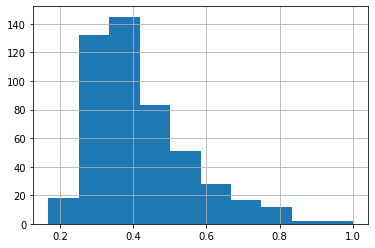

In [142]:
pred_data.score.hist(bins=10)

In [48]:
pred_data[pred_data.score < 0.01]

,score,database_idx,query_idx


In [93]:
train[0:30]

,idx,item_nm,first_w,first_2w,class
0,7062,Кольцо уплотнительное шарикового подшипника,Кольцо,Кольцо уплотнительное,1
1,7203,Корпус подшипника,Корпус,Корпус подшипника,13
2,35,Кран гидравлический замедлительный М18/М18,Кран,Кран гидравлический,92
3,7023,Труба K-Flex ST 13х22 (2м),Труба,Труба K-Flex,22
4,430,Болт M12x30 Kuhn,Болт,Болт M12x30,3
5,6844,"Гайка барашковая (G 3/4"")",Гайка,Гайка барашковая,11
6,1650,Ступица заднего колеса Т15,Ступица,Ступица заднего,38
7,6515,Распылитель ID3 120 (120-01),Распылитель,Распылитель ID3,19
8,3976,Кронштейн,Кронштейн,Кронштейн,35
9,4891,"Цепь роликовая, 57 звеньев",Цепь,"Цепь роликовая,",29


In [104]:
train['after_r'] =  train['item_nm'].str.findall('([а-яА-Я ]*)\d*.*').str.join(' ')

In [106]:
train[train['after_r'] == ' ']

,idx,item_nm,first_w,first_2w,class,after_r
46,3019,KM385BT Насос масляный,KM385BT,KM385BT Насос,156,
70,5800,R180 Шатун,R180,R180 Шатун,30,
74,3400,ZS1115 Плита крепления электростартера,ZS1115,ZS1115 Плита,53,
87,6816,R190-R195 Втулка шатуна,R190-R195,R190-R195 Втулка,45,
113,6613,ZS1100 Насос масляный,ZS1100,ZS1100 Насос,54,
...,...,...,...,...,...,...
4853,5635,"R195 Поршневой комплект A=38 мм (поршень, пале...",R195,R195 Поршневой,60,
4856,198,"ZS1115 Штанги, 2 шт.",ZS1115,"ZS1115 Штанги,",53,
4860,5096,"ZS1115 Манжеты гильзы, 2 шт.",ZS1115,ZS1115 Манжеты,53,
4861,4241,"R195 Поршневой комплект A=42 мм (поршень, пале...",R195,R195 Поршневой,60,


In [137]:
train['item_nm'].str.findall('[а-яА-Я]{2,}').str.join(' ').value_counts()[-30:]

Колесо прикатывающее пластик                                               1
Сальник ВОМ Уралец                                                         1
Реле зарядки проводами конт                                                1
Лемех левый мм                                                             1
Крышка мотоблока правая под первичный вал                                  1
Колесо сборе                                                               1
Гайка прорезью                                                             1
Крышка задняя торцевая мм Уралец Синтай                                    1
Втулка буртиком                                                            1
Рычаг отжимной Лапка сцепления                                             1
Фонарь освещения знака номерного КАМАЗ КРАЗ                                1
Шток поршня гидробака                                                      1
Болт для крепления ножа почвофрезы Виракс гайкой гровером                  1

In [138]:
train['item_nm'].str.findall('[а-яА-Я]{2,}').str.join(' ').value_counts()[:30]

Подшипник                                   94
Болт                                        83
Кольцо уплотнительное                       67
Втулка                                      64
Распылитель                                 63
Шайба                                       63
Винт                                        55
Гайка                                       53
Палец                                       48
Сальник                                     45
Кольцо                                      33
Пластина                                    31
Вал                                         31
Уплотнение                                  30
Труба                                       29
Пресс фитинг                                29
Уплотнительное кольцо                       28
Штифт                                       28
Пружина                                     27
Кронштейн                                   26
Штуцер прямой под вилочное соединение мм    26
Фильтр топлив

In [134]:
train['item_nm'].str.findall('[а-яА-Я]+')

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Подшипник]                                                                       87
[Болт]                                                                            76
[Втулка]                                                                          64
[Шайба]                                                                           62
[Распылитель]                                                                     58
                                                                                  ..
[Рукоятка, зуба, левая]                                                            1
[Болт, М, х, для, крепления, ножа, почвофрезы, Виракс, с, гайкой, и, гровером]     1
[Муфта, х, мм]                                                                     1
[Шток, поршня, гидробака]                                                          1
[Отвал, коммунальный, плужный]                                                     1
Name: item_nm, Length: 1893, dtype: int64

In [53]:
train['item_nm'].value_counts()[:30]

Подшипник                53
Болт                     51
Втулка                   47
Шайба                    46
Палец                    33
Гайка                    31
Вал                      27
Уплотнительное кольцо    25
Кронштейн                25
Пластина                 25
Уплотнение               24
Кольцо                   23
Кольцо уплотнительное    22
Штифт                    22
Пружина                  22
Рукав гидравлический     20
Винт                     18
Шланг гидравлический     17
Диск                     16
Цепь                     16
Шланг                    14
Комплект уплотнений      13
Фильтр                   12
Корпус подшипника        12
Звездочка                12
Ремень                   12
Крышка                   11
Фильтр воздушный         11
Ступица                  11
Прокладка                10
Name: item_nm, dtype: int64

In [65]:
train['first_w'] = train['item_nm'].str.split(' ').str[0]
train['first_2w'] = train['item_nm'].str.split(' ').str[0:2].str.join(" ")

In [66]:
train['first_w'].value_counts()

Фильтр       166
Кольцо       163
Подшипник    148
Болт         127
Прокладка    119
            ... 
WF207          1
Усиление       1
Глушитель      1
AP1000476      1
Винт,          1
Name: first_w, Length: 359, dtype: int64

In [67]:
train['first_2w'].value_counts()

Кольцо уплотнительное    75
Штуцер прямой            55
Подшипник                53
Болт                     51
Втулка                   47
                         ..
Амортизатор Ares          1
Кабель D7                 1
Вентилятор 052            1
Фитинг M16x1,5            1
Покрышка 7.50&quot;       1
Name: first_2w, Length: 1707, dtype: int64

In [86]:
value_counts_dict = dict(train['first_w'].value_counts())
value_counts_dict['Фильтр']
value_counts_enumerate = {k: i for i, k in enumerate(value_counts_dict)}

In [89]:
train['class'] = train['first_w'].apply(lambda x: value_counts_enumerate[x] if value_counts_dict[x] > 5 else -99)